<a href="https://colab.research.google.com/github/DuyDucNguyen/Practical_FEM_FEniCS_Colab/blob/master/helmhurts_complex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helmhurts Equation

In [0]:
# This program shows how to implement Helmhurts equation

# Reference: This program is followed the ideas in last chapter of the course 'edx.org - KTHx - High Performance Finite Element Modeling'. 
# The author modifies it up to date and give clear explaination.  

# Copyright (C) 2019 Duy Duc NGUYEN (duyduc.nguyen@protonmail.com)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2019-09-28
# Last changed: 2019-09-28

# This demo is maintained by Duy Duc NGUYEN
# Please report possible problems to duyduc.nguyen@protonmail.com

In [4]:
import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

E: Package 'python-software-properties' has no installation candidate
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [564 B]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [70.9 kB]
Get:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu18

Helhurt equation is given by

\begin{equation}
\Delta p+k^{2}p=f \text{ in } \Omega
\end{equation}

Weak form 
\begin{equation}
-\int_{\Omega}\nabla p\cdot\nabla\overline{p}\ \mathrm{d}x+k^{2}\int_{\Omega}p\overline{p}\ \mathrm{d}x=\int_{\Omega}f\overline{p}\ \mathrm{d}x
\end{equation}

If $p=p_{r}+ip_{i}$, we get the system

\begin{equation}
\left\{ \begin{array}{ccc}
\Delta p_{r}+k^{2}p_{r}=f_{r} & \text{ in } & \Omega\\
\Delta p_{i}+k^{2}p_{i}=f_{i} & \text{ in } & \Omega
\end{array}\right.
\end{equation}
weak form 
\begin{align*}
F_{r} & =-\int_{\Omega}\nabla p_{r}\cdot\nabla\overline{p}_{r}\ \mathrm{d}x+k^{2}\int_{\Omega}p_{r}\overline{p}_{r}\ \mathrm{d}x-\int_{\Omega}f_{r}\overline{p}_{r}\ \mathrm{d}x\\
F_{i} & =-\int_{\Omega}\nabla p_{i}\cdot\nabla\overline{p}_{i}\ \mathrm{d}x+k^{2}\int_{\Omega}p_{i}\overline{p}_{i}\ \mathrm{d}x-\int_{\Omega}f_{i}\overline{p}_{i}\ \mathrm{d}x\\
F & =F_{r}+F_{i}
\end{align*}


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


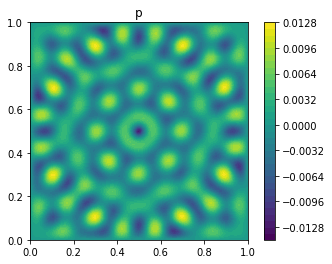

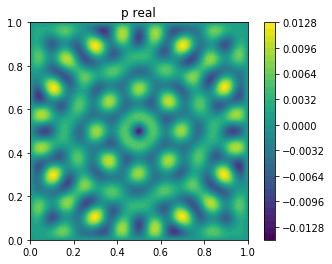

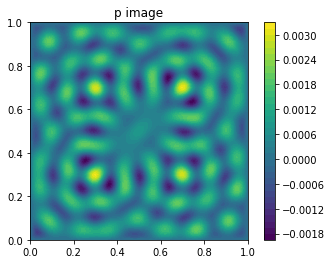

In [5]:
import matplotlib.pyplot as plt
import sys

# Refs: http://jasmcole.com/2014/08/25/helmhurts/


def read_h5(filename = 'file.h5'):
	'''Description: Convert mesh written in XML format into H5 format
	   Write mesh tags (boundaries, domains) into H5 file
	   Input:  XML mesh
	   Output: H5 mesh
	'''
	mesh = Mesh()
	hdf = HDF5File(mesh.mpi_comm(), filename, "r")
	hdf.read(mesh, "/mesh", False)
	dim = mesh.topology().dim()
	cell_markers = MeshFunction("size_t", mesh, dim)
	hdf.read(cell_markers, "/cell_markers")
	facet_markers = MeshFunction("size_t", mesh, dim-1)
	hdf.read(facet_markers, "/facet_markers")
	return mesh, cell_markers, facet_markers

'''try:
    k = float(sys.argv[1])
    print ("Setting k equal to %.1f" % k)
except IndexError:
    k = 50.0
'''

# parameters
k = Constant(50.0)  # 2.4 GHz / c

# function space
mesh = UnitSquareMesh(100, 100)
V = FunctionSpace(mesh, "CG", 1)

# functions
dp = TrialFunction(V); tp = TestFunction(V); p = Function(V)

# boundary condition
def allboundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0.0), allboundary)


# source 
f_str = '100.0*exp( - ( pow((x[0] - Bx)/sigma_x, 2.0) + pow((x[1] - By)/sigma_y, 2.0) )) '
f =  Expression( f_str, degree = 1, Bx = 0.5, By = 0.5, sigma_x = 0.01, sigma_y = 0.01)


# F form
a = ((k**2)*inner(dp, tp) - inner(nabla_grad(dp), nabla_grad(tp)) )*dx
L = f*tp*dx
F = a - L 


# Solve system
F = action(F,p)
solve(F==0, p, bc)


# Plot and export solution
plt.figure()
pl = plot(p)
plt.title('p')
plt.colorbar(pl)



# complex function space
fi_ele   = FiniteElement('CG', mesh.ufl_cell(), 1)
elements = MixedElement([fi_ele, fi_ele])
W        = FunctionSpace(mesh, elements)

# Define trial function
dunks = TrialFunction(W); (dpr, dpi) = split(dunks)
unks = Function(W); (pr, pi) = split(unks);
tests = TestFunction(W); (tpr, tpi) = split(tests);

# boundary condition
pr_bc = DirichletBC(W.sub(0), Constant(0.0), allboundary)
pi_bc = DirichletBC(W.sub(1), Constant(0.0), allboundary)
p_bc = [pr_bc, pi_bc]


# source (assumptions)
fr = f
fi = Constant(1.0)

# F form
Fr = ((k**2)*inner(dpr, tpr) - inner(nabla_grad(dpr), nabla_grad(tpr)) )*dx - fr*tpr*dx
Fi = ((k**2)*inner(dpi, tpi) - inner(nabla_grad(dpi), nabla_grad(tpi)) )*dx - fi*tpi*dx
Fc = Fr + Fi
Fc = action(Fc, unks)

# solve
solve(Fc==0, unks, p_bc)
pr_, pi_ = unks.split(True)

plt.figure()
prp = plot(pr_)
plt.title('p real')
plt.colorbar(prp)

plt.figure()
pip = plot(pi_)
plt.title('p image')
plt.colorbar(pip)

plt.show()

